In [2]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..', '..'))
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from src.LoadEcoCounterData import EcoCounterData as BikeData

import matplotlib.pyplot as plt
import src.BikeDataPlotter as BikePlotter
import src.Colortheme as ct
from tueplots import bundles

# Paper Figure: Weekday Comparison of Winter and Summer

In [3]:
bd = BikeData()

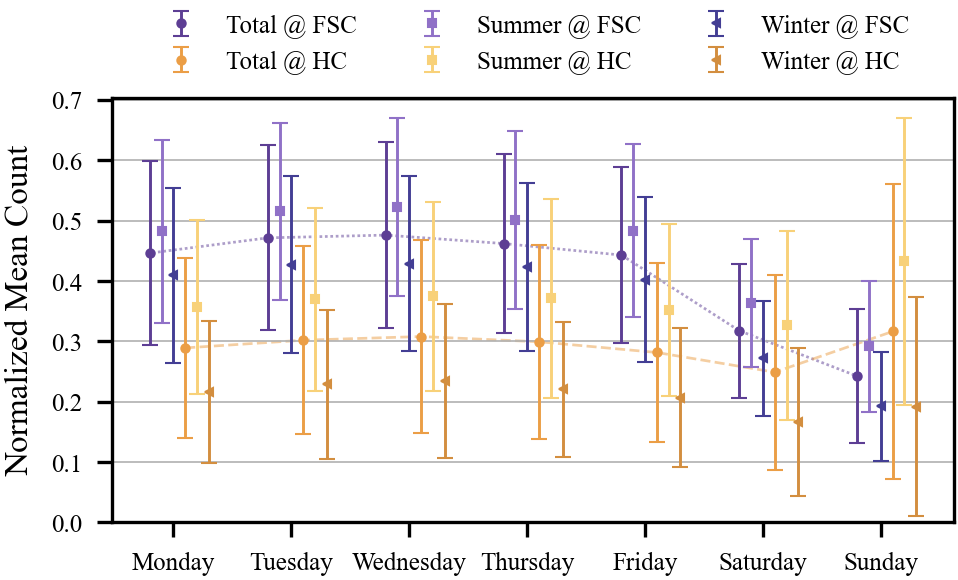

In [20]:
# get corrected data
df = bd.get_daily_data()

# separate Fahrradtunnel and Steilachallee from Hirschau
df_city = df[df["counter_site_id"].isin([100003358, 100003359])].copy()
df_hirschau = df[df["counter_site_id"].isin([100026408])].copy()
df_city = df_city.groupby(["iso_timestamp", "weekday"])["zählstand"].mean().reset_index()

df_city["zählstand"] /= df_city["zählstand"].max()
df_hirschau["zählstand"] /= df_hirschau["zählstand"].max()
# extract seasons per counter
# city
df_city_summer = df_city[(df_city["iso_timestamp"].dt.month >= 3) & (df_city["iso_timestamp"].dt.month <= 8)].copy()
df_city_winter = df_city[(df_city["iso_timestamp"].dt.month >= 9) | (df_city["iso_timestamp"].dt.month <= 2)].copy()

# hirschau
df_hirschau_summer = df_hirschau[(df_hirschau["iso_timestamp"].dt.month >= 3) & (df_hirschau["iso_timestamp"].dt.month <= 8)].copy()
df_hirschau_winter = df_hirschau[(df_hirschau["iso_timestamp"].dt.month >= 9) | (df_hirschau["iso_timestamp"].dt.month <= 2)].copy()

# compute mean and std over weekdays
# city
df_city_weekday = df_city.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()
df_city_summer_weekday = df_city_summer.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()
df_city_winter_weekday = df_city_winter.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()

# Hirschau
df_hirschau_weekday = df_hirschau.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()
df_hirschau_summer_weekday = df_hirschau_summer.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()
df_hirschau_winter_weekday = df_hirschau_winter.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()

lst_city = [df_city_weekday, df_city_summer_weekday, df_city_winter_weekday]
lst_hirschau = [df_hirschau_weekday, df_hirschau_summer_weekday, df_hirschau_winter_weekday]
season = ["Total", "Summer", "Winter"]
data = [lst_city, lst_hirschau]

plt.rcParams.update({"figure.dpi": 300})
plt.rcParams.update(bundles.icml2022(column="half", family="serif", usetex=False, nrows=.99, ncols=1))
plt.rcParams['font.serif'] = "Times New Roman"

fig, ax = plt.subplots()
offset_sz = .3
season_color = {
        0: [BikePlotter.COUNTER["FSC"]["color"], BikePlotter.COUNTER[100026408]["color"]],    # COUNTERS
        1: [BikePlotter.COUNTER["FSC"]["color"]+0.2, BikePlotter.COUNTER[100026408]["color"]+[0.05,0.2,0.2]], # SUMMER
        2: [BikePlotter.COUNTER["FSC"]["color"]+[-.1,0,0], BikePlotter.COUNTER[100026408]["color"]*0.9]     # WINTER
}
marker_style = {
    0: "o",
    1: "s",
    2: "<"
}
# line_mean = data.copy()
for didx, d in enumerate(data):
    for sidx, s in enumerate(season):
        weekday_df = data[didx][sidx]

        # offset for plotting # TODO: pot make distance to hirschau greater
        offset = [
            (offset_sz * len(data)) / len(season),
            offset_sz * (didx + (sidx / len(season)))
        ]
        weekday_df["weekday"] -= offset[0]
        weekday_df["weekday"] += offset[1]

        fmt = marker_style[sidx]
        counter = "FSC" if didx == 0 else "HC"
        # alpha = 1 if sidx == 0 else 0.5
        #  =  if didx == 1 and sidx > 0 else 1
        # color_fac = 1.01 if didx == 0 else 0.9
        color_fac=1
        ax.errorbar(
            weekday_df["weekday"],weekday_df["mean"],
            yerr=weekday_df["std"],fmt=fmt,
            lw=.7,markeredgewidth=.5,ms=2,capsize=2,
            label=f"{s} @ {counter}",
            color=season_color[sidx][didx]*color_fac,
        )

    ax.plot(
        d[0]["weekday"],d[0]["mean"],
        color=season_color[0][didx],
        alpha=0.5,lw=.65,linestyle=(1,(1,1)) if didx == 0 else "--",
        zorder=0
        # label=f"{counter}"
    )
ax.set_ylabel("Normalized Mean Count")
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.grid(axis="y", lw=0.4)
ax.set_ylim(bottom=0)
handles, labels = ax.get_legend_handles_labels()
order = [0,3,1,4,2,5]
new_labels_order = [labels[idx] for idx in order]
# new_labels_order.insert(0,custom_legend[1])
new_handles_order = [handles[idx] for idx in order]
plt.legend(new_handles_order, new_labels_order , bbox_to_anchor=(0.5,1.25), ncol=3, loc="upper center", frameon=False)
# plt.show()
plt.savefig("fig_weekly_winter_summer.pdf")